['D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0001_AGE_0069_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0002_AGE_0074_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0003_AGE_0075_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0004_AGE_0056_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0005_AGE_0048_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0006_AGE_0075_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0007_AGE_0061_CONTRAST_1_CT.tif', 'D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\tiff_images\\ID_0008_AGE_0051_CON

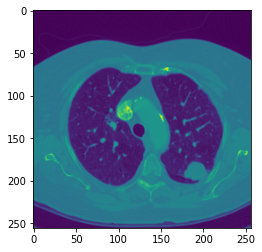

In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from glob import glob
from skimage.io import imread
import re 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

def load_data():
    #read images from the tif files
    BASE_IMG_PATH='D:\\DSS_Visual_Analytics_XAI\\Code\\MMD-critic-master\\data_medical_images\\'
    all_images_list = glob(os.path.join(BASE_IMG_PATH,'tiff_images','*.tif'))
    all_images_list[:5]
    print(all_images_list)

    #print(os.listdir(BASE_IMG_PATH))
    #print(os.path.join(BASE_IMG_PATH,'tiff_images','*.tif'))

    print(imread(all_images_list[0]).shape)
    np.expand_dims(imread(all_images_list[0])[::4,::4],0).shape
    jimread = lambda x: np.expand_dims(imread(x)[::2,::2],0)
    test_image = jimread(all_images_list[1])
    print(test_image[0].shape)
    plt.imshow(test_image[0])

    return all_images_list

all_images_list = load_data()

In [85]:
len(all_images_list)

99

TRAIN TEST SPLIT

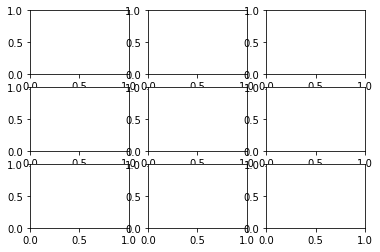

In [116]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


def label_extraction(all_images_list):
    check_contrast = re.compile(r'ID_([\d]+)_AGE_[\d]+_CONTRAST_([\d]+)_CT')
    label = []
    id_list = []
    for image in all_images_list:
        id_list.append(check_contrast.findall(image)[0][0])
        label.append(check_contrast.findall(image)[0][1])

    return pd.DataFrame(label,id_list)

label_list = label_extraction(all_images_list)

#print(label_list.head())


def data_augmentation():

    images = np.stack([jimread(i) for i in all_images_list],0) 

    X_new = []
    for i in range(len(images)):
        # load the image
        img = images[i].reshape(images[i].shape[1],images[i].shape[2] )
        # convert to numpy array
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(rotation_range=90)
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot
        for i in range(9):
            # define subplot
            pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            X_new.append(image)
        
    return np.asarray(X_new)

def label_augmentation():       
    y = label_list.values

    y_new = []
    for i in y:
        for j in range(9):
            y_new.append(i)

    return np.asarray(y_new)

X = data_augmentation()
y = label_augmentation()
        
# Split train and test sets
X_train, X__test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]*0.5), random_state=0)

In [117]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((446, 256, 256, 1), (446, 1), (446, 256, 256, 1), (445, 1))

In [89]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.datasets import mnist

print("Using Tensorflow:", tf.__version__)

Using Tensorflow: 2.7.0


In [90]:
from distutils.version import LooseVersion

assert LooseVersion(tf.__version__) >= LooseVersion("2.0.0"), \
    "This notebook requires TensorFlow 2.0 or above."

d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
print(y_train.shape)
print(y_test.shape)

(446, 1)
(445, 1)


In [92]:
y = np.concatenate((y_train, y_test))

In [93]:
y.reshape(1,-1)[0]
y = y.reshape(1,-1)[0].astype(int)


In [94]:
y

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,

In [95]:
def make_risk_score_for_groups(y: np.ndarray,
                               n_groups: int = 2,
                               seed: int = 89) -> Tuple[pd.DataFrame, np.ndarray]:
    rnd = np.random.RandomState(seed)

    # assign class labels `y` to one of `n_groups` risk groups
    classes = np.unique(y)
    #print(classes)
    classes = classes[::-1]
    group_assignment = {}
    group_members = {}
    groups = rnd.randint(n_groups, size=classes.shape)
    for label, group in zip(classes, groups):
        group_assignment[label] = group
        group_members.setdefault(group, []).append(label)

    # assign risk score to each class label in `y`
    risk_per_class = {}
    for label in classes:
        group_idx = group_assignment[label]
        group = group_members[group_idx]
        label_idx = group.index(label)
        group_size = len(group)

        # allow risk scores in each group to vary slightly
        risk_score = np.sqrt(group_idx + 1e-4) * 1.75
        risk_score -= (label_idx - (group_size // 2)) / 25.
        risk_per_class[label] = risk_score

    assignment = pd.concat((
        pd.Series(risk_per_class, name="risk_score"),
        pd.Series(group_assignment, name="risk_group")
    ), axis=1).rename_axis("class_label")
        
    risk_scores = np.array([risk_per_class[yy] for yy in y])
    return assignment, risk_scores


risk_score_assignment, risk_scores = make_risk_score_for_groups(y)

risk_score_assignment.round(3)

,risk_score,risk_group
class_label,,
1,1.750,1
0,0.018,0


In [96]:
class SurvivalTimeGenerator:

    def __init__(self,
                 num_samples: int,
                 mean_survival_time: float,
                 prob_censored: float) -> None:
        self.num_samples = num_samples
        self.mean_survival_time = mean_survival_time
        self.prob_censored = prob_censored

    def gen_censored_time(self,
                          risk_score: np.ndarray,
                          seed: int = 92) -> Tuple[np.ndarray,np.ndarray]:
        rnd = np.random.RandomState(seed)
        # generate survival time
        baseline_hazard = 1. / self.mean_survival_time
        scale = baseline_hazard * np.exp(risk_score)
        u = rnd.uniform(low=0, high=1, size=risk_score.shape[0])
        t = -np.log(u) / scale

        # generate time of censoring
        qt = np.quantile(t, 1.0 - self.prob_censored)
        c = rnd.uniform(low=t.min(), high=qt)

        # apply censoring
        observed_event = t <= c
        observed_time = np.where(observed_event, t, c)
        return observed_time, observed_event


surv_gen = SurvivalTimeGenerator(
    num_samples=y.shape[0],
    mean_survival_time=365.,
    prob_censored=.40
)
time, event = surv_gen.gen_censored_time(risk_scores)
time_train = time[:y_train.shape[0]]
event_train = event[:y_train.shape[0]]
time_test = time[y_train.shape[0]:]
event_test = event[y_train.shape[0]:]

print("%.2f%% samples are right censored in training data." % (np.sum(~event_train) * 100. / len(event_train)))
print("%.2f%% samples are right censored in test data." % (np.sum(~event_test) * 100. / len(event_test)))

46.19% samples are right censored in training data.
42.02% samples are right censored in test data.


In [97]:
y_train = y_train.reshape(1,-1).astype(int)
y_test = y_test.reshape(1,-1).astype(int)

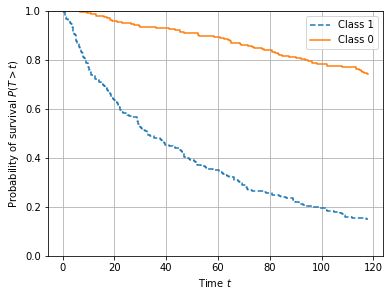

In [98]:
styles = ('-', '--')

plt.figure(figsize=(6, 4.5))
for row in risk_score_assignment.itertuples():
    mask = y_train.reshape(1,-1).astype(int) == row.Index
    #print(mask[0]) # εδω εβαλα mask[0]
    coord_x, coord_y = kaplan_meier_estimator(event_train[mask[0]], time_train[mask[0]])
    ls = styles[row.risk_group]
    plt.step(coord_x, coord_y, where="post", label=f"Class {row.Index}", linestyle=ls)
plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()
plt.legend()

In [99]:
x_train  = X_train
x_test = X_test

time.shape, event.shape, time_train.shape, time_test.shape, event_train.shape, event_test.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((891,),
 (891,),
 (446,),
 (445,),
 (446,),
 (445,),
 (446, 256, 256, 1),
 (446, 256, 256, 1),
 (1, 446),
 (1, 445))

In [100]:
cindex = concordance_index_censored(event_test, time_test, risk_scores[y_train.reshape(-1,1).shape[0]:])

print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")

Concordance index on test data with actual risk scores: 0.673


In [101]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

In [102]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

In [103]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2


class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                summary_ops_v2.graph(func.graph) #, step=0)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 200 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

DeepCNNSurv - Model

In [104]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((446, 256, 256, 1), (446, 256, 256, 1), (1, 446), (1, 445))

In [105]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

In [106]:
train_fn = InputFunction(x_train, time_train, event_train,
                  drop_last=True,
                  shuffle=True)

eval_fn = InputFunction(x_test, time_test, event_test)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("ckpts-mnist-c"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=30,
)

In [108]:
trainer.train_and_evaluate()

step 0: mean loss = 9.7017


UnknownError: IndexError: index 445 is out of bounds for axis 0 with size 445
Traceback (most recent call last):

  File "d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\tensorflow\python\ops\script_ops.py", line 275, in __call__
    ret = func(*args)

  File "d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\geo_m\AppData\Local\Temp/ipykernel_23000/414494161.py", line 106, in _iter_data
    yield self._get_data_batch(idx)

  File "C:\Users\geo_m\AppData\Local\Temp/ipykernel_23000/414494161.py", line 80, in _get_data_batch
    time = self.time[index]

IndexError: index 445 is out of bounds for axis 0 with size 445


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 252, 252, 6)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 6)      0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 122, 122, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense_1 (Dense)             (None, 120)               7

Save the model 

In [ ]:
from keras.models import save_model

# model = Your trained model. Of course you can save the model wherever you like and modify the directory accordingly
model.save('model.h5')

Load the model 

In [ ]:
from tensorflow import keras
model = keras.models.load_model('C:\\Users\\geo_m\\Downloads\\model.h5')
print(model)

FEATURE EXTRACTOR 

In [29]:
model.layers

In [28]:
from keras.models import Model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

VISUALIZATION 

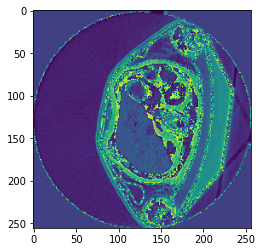

In [69]:
import matplotlib.pyplot as plt 
plt.imshow(x_test[1].reshape(x_test[0].shape[1], x_test[0].shape[1]))

In [70]:
x_test[1].shape

(256, 256, 1)

Use FEATURE EXTRACTOR in order to pass through all the data and return vectors of (important) features extracted 

In [33]:
import numpy as np 

x_test = X_test

vectors_extracted = []
for i in range(len(x_test)):
    features = model.predict(x_test[i].reshape(1, 256, 256, 1))
    vectors_extracted.append(features)

RESHAPE THE VECTORS

In [34]:
print(np.asarray(vectors_extracted).shape)
vectors_reshaped = np.asarray(vectors_extracted).reshape(np.asarray(vectors_extracted).shape[0],np.asarray(vectors_extracted).shape[1],np.asarray(vectors_extracted).shape[2])
vectors_reshaped.shape

(446, 1, 84)


(446, 1, 84)

In [35]:
vectors_reshaped.shape

(446, 1, 84)

In [36]:
holistic_table = pd.DataFrame(event_test, columns=['Events'])
holistic_table

,Events
0,True
1,True
2,False
3,True
4,True
...,...
441,True
442,False
443,True
444,False


In [37]:
holistic_table['Time'] = pd.DataFrame(time_test)

holistic_table

,Events,Time
0,True,64.981901
1,True,70.283690
2,False,113.797176
3,True,72.383574
4,True,33.536397
...,...,...
441,True,40.069037
442,False,113.797176
443,True,37.866360
444,False,113.797176


TSNE

In [38]:
from sklearn.manifold import TSNE
vectors_reshaped[0]
X_embedded = TSNE(n_components=2).fit_transform(vectors_reshaped.reshape(vectors_reshaped.shape[0], vectors_reshaped.shape[2]))
X_embedded.shape

(446, 2)

PCA

In [62]:
from sklearn.decomposition import PCA

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=2, random_state=43)
pca.fit(vectors_reshaped.reshape(vectors_reshaped.shape[0], vectors_reshaped.shape[2]))
X_embedded_pca = pca.transform(vectors_reshaped.reshape(vectors_reshaped.shape[0], vectors_reshaped.shape[2]))

KMEANS clustering (either with or without dimensionality reduction before) 

In [63]:
# clustering and dimension reduction
from sklearn.cluster import KMeans


# cluster feature vectors
kmeans = KMeans(n_clusters=2,n_jobs=-1)
kmeans.fit(X_embedded_pca) # use X_embedded or X_embedded_pca here if you want to include dimensionality reduction in your process

d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=2, n_jobs=-1)

USE KMEANS LABELS

In [64]:
holistic_table['Labels'] = pd.DataFrame(kmeans.labels_)

holistic_table.head()

,Events,Time,Labels
0,True,64.981901,0
1,True,70.283690,0
2,False,113.797176,1
3,True,72.383574,1
4,True,33.536397,1


        Labels
0    High Risk
1    High Risk
2     Low Risk
3     Low Risk
4     Low Risk
..         ...
441  High Risk
442   Low Risk
443  High Risk
444   Low Risk
445  High Risk

[446 rows x 1 columns]


d:\DSS_Visual_Analytics_XAI\Code\Explainability\explainability\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


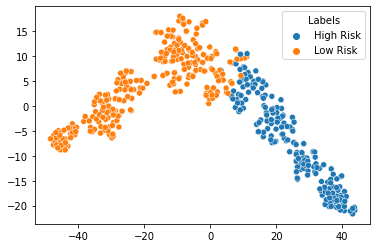

In [65]:
import seaborn as sns 

table_ = pd.DataFrame(holistic_table['Labels'].values, columns = ['Labels'])

table_.loc[table_['Labels'] == 1, 'Labels'] = 'Low Risk'
table_.loc[table_['Labels'] == 0, 'Labels'] = 'High Risk'
print(table_)
ax = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=table_['Labels'], legend='full')
ax.axes.xaxis.set_visible(True)
ax.axes.yaxis.set_visible(True)
plt.show()

In [66]:
time.shape, event.shape, time_train.shape, time_test.shape, event_train.shape, event_test.shape

((891,), (891,), (445,), (446,), (445,), (446,))

     Events        Time  Labels
2     False  113.797176       1
3      True   72.383574       1
4      True   33.536397       1
5      True    4.531322       1
11     True   24.412328       1
..      ...         ...     ...
437    True   17.104595       1
438   False  113.797176       1
439   False  113.797176       1
442   False  113.797176       1
444   False  113.797176       1

[262 rows x 3 columns]
     Events        Time  Labels
0      True   64.981901       0
1      True   70.283690       0
6     False  113.797176       0
7      True    4.789344       0
8      True  113.707619       0
..      ...         ...     ...
435    True   71.910787       0
440    True   62.194125       0
441    True   40.069037       0
443    True   37.866360       0
445    True   70.169348       0

[184 rows x 3 columns]
(262, 3)
(184, 3)


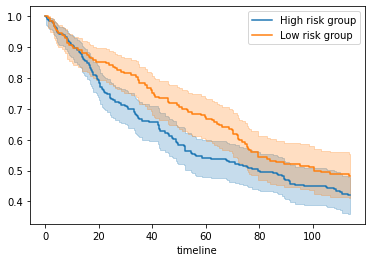

In [67]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

group_1 = holistic_table[holistic_table['Labels'] == 1]
print(group_1)
group_0 = holistic_table[holistic_table['Labels'] == 0]
print(group_0)
#group_2 = holistic_table[holistic_table['Labels'] == 2]
#print(group_2)
#group_3 = holistic_table[holistic_table['Labels'] == 3]
#print(group_3)

kmf1 = KaplanMeierFitter() 
kmf1.fit(group_1['Time'], group_1['Events'], label="High risk group")

kmf0 = KaplanMeierFitter() 
kmf0.fit(group_0['Time'], group_0['Events'], label="Low risk group")

#kmf2 = KaplanMeierFitter() 
#kmf2.fit(group_2['Time'], group_2['Events'])

#kmf3 = KaplanMeierFitter() 
#kmf3.fit(group_3['Time'], group_3['Events'])

ax = kmf1.plot()
ax = kmf0.plot(ax = ax)
#ax = kmf2.plot(ax = ax)
#ax = kmf3.plot(ax = ax)


print(group_1.shape)
print(group_0.shape)
#print(group_2.shape)
#print(group_3.shape)

#results = multivariate_logrank_test(holistic_table['Time'], holistic_table['Labels'], holistic_table['Events'])
results = logrank_test(group_1['Time'], group_0['Time'], event_observed_A=group_1['Events'], event_observed_B=group_0['Events'])

In [68]:
results.p_value

0.0931079032723156